In [1]:
# PROJECT 2 (Option B): ASL Classification using RED DOT LANDMARKS + SVM

from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report
)

# --------------------------
# 1) PATHS (EDIT THESE)
# --------------------------
TRAIN_DIR = Path(r"C:\Users\Vartotojas\Documents\AIA Project 2\split_dataset\train")
TEST_DIR  = Path(r"C:\Users\Vartotojas\Documents\AIA Project 2\split_dataset\test")

assert TRAIN_DIR.exists(), f"Train path not found: {TRAIN_DIR}"
assert TEST_DIR.exists(), f"Test path not found: {TEST_DIR}"

print("TRAIN_DIR:", TRAIN_DIR)
print("TEST_DIR :", TEST_DIR)

# --------------------------
# 2) HELPERS
# --------------------------
def is_image_file(p: Path) -> bool:
    e = str(p).lower()
    return any(e.endswith(x) for x in [".jpg",".jpeg",".png",".bmp",".webp",".tiff"])

# --------------------------
# 3) CLASSES
# --------------------------
class_names = sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()])
class_to_idx = {c: i for i, c in enumerate(class_names)}
num_classes = len(class_names)

print("Num classes:", num_classes)
print("First 10:", class_names[:10])

# Ensure test has same classes
test_class_names = sorted([d.name for d in TEST_DIR.iterdir() if d.is_dir()])
assert test_class_names == class_names, "Train/Test class folders do not match!"


TRAIN_DIR: C:\Users\Vartotojas\Documents\AIA Project 2\split_dataset\train
TEST_DIR : C:\Users\Vartotojas\Documents\AIA Project 2\split_dataset\test
Num classes: 27
First 10: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


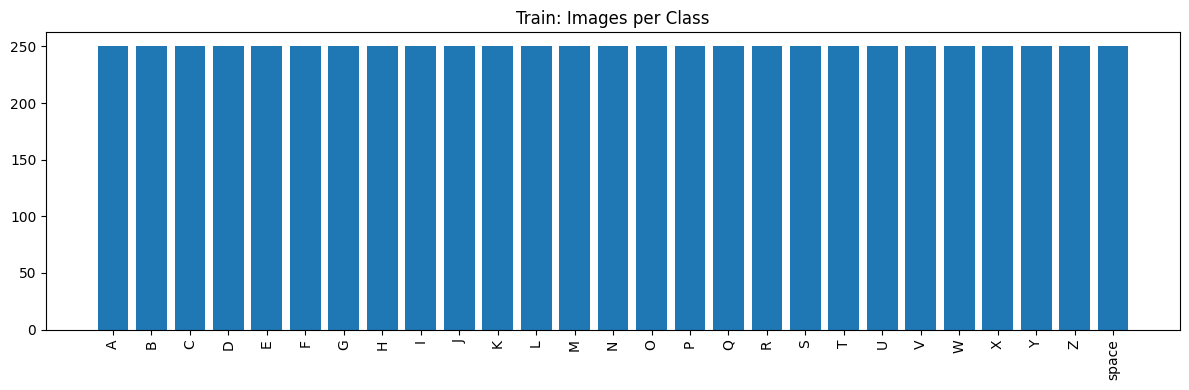

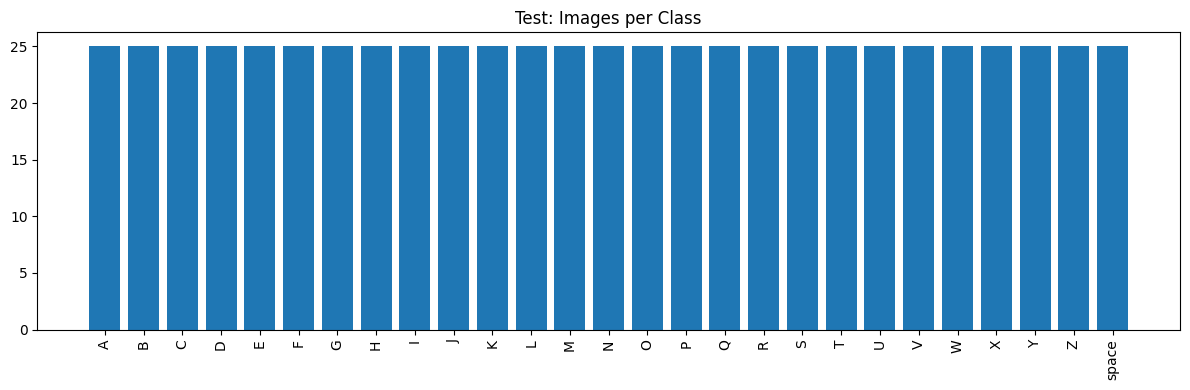

In [2]:

# --------------------------
# 4) DISTRIBUTION PLOTS (like Project 1)
# --------------------------
def count_images_per_class(root_dir: Path):
    rows = []
    for cls in class_names:
        folder = root_dir / cls
        n = sum(1 for p in folder.glob("*") if is_image_file(p))
        rows.append({"class": cls, "count": n})
    return pd.DataFrame(rows)

df_train_counts = count_images_per_class(TRAIN_DIR)
df_test_counts  = count_images_per_class(TEST_DIR)

plt.figure(figsize=(12,4))
plt.bar(df_train_counts["class"], df_train_counts["count"])
plt.xticks(rotation=90)
plt.title("Train: Images per Class")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.bar(df_test_counts["class"], df_test_counts["count"])
plt.xticks(rotation=90)
plt.title("Test: Images per Class")
plt.tight_layout()
plt.show()



Extracting red-dot landmarks for TRAIN...
Debug example: C:\Users\Vartotojas\Documents\AIA Project 2\split_dataset\train\A\A_train_0049.jpg


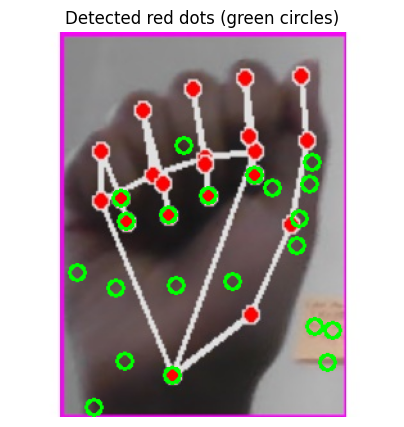

Extracting red-dot landmarks for TEST...

--- EXTRACTION SUMMARY ---
Train total: 6750, usable: 1027, failed: 5723
Test  total: 675, usable: 101,  failed: 574
Feature dim: 63
Saved: asl_red_dots_* arrays + labels

Training SVM...

SVM Accuracy: 0.8118811881188119

Classification Report:

              precision    recall  f1-score   support

           A     0.0000    0.0000    0.0000         1
           B     0.0000    0.0000    0.0000         0
           C     0.0000    0.0000    0.0000         0
           D     0.0000    0.0000    0.0000         0
           E     0.0000    0.0000    0.0000         1
           F     0.0000    0.0000    0.0000         0
           G     0.0000    0.0000    0.0000         0
           H     0.9231    0.9231    0.9231        13
           I     0.8947    0.9444    0.9189        18
           J     1.0000    0.6667    0.8000         3
           K     1.0000    1.0000    1.0000         4
           L     0.0000    0.0000    0.0000         0
        

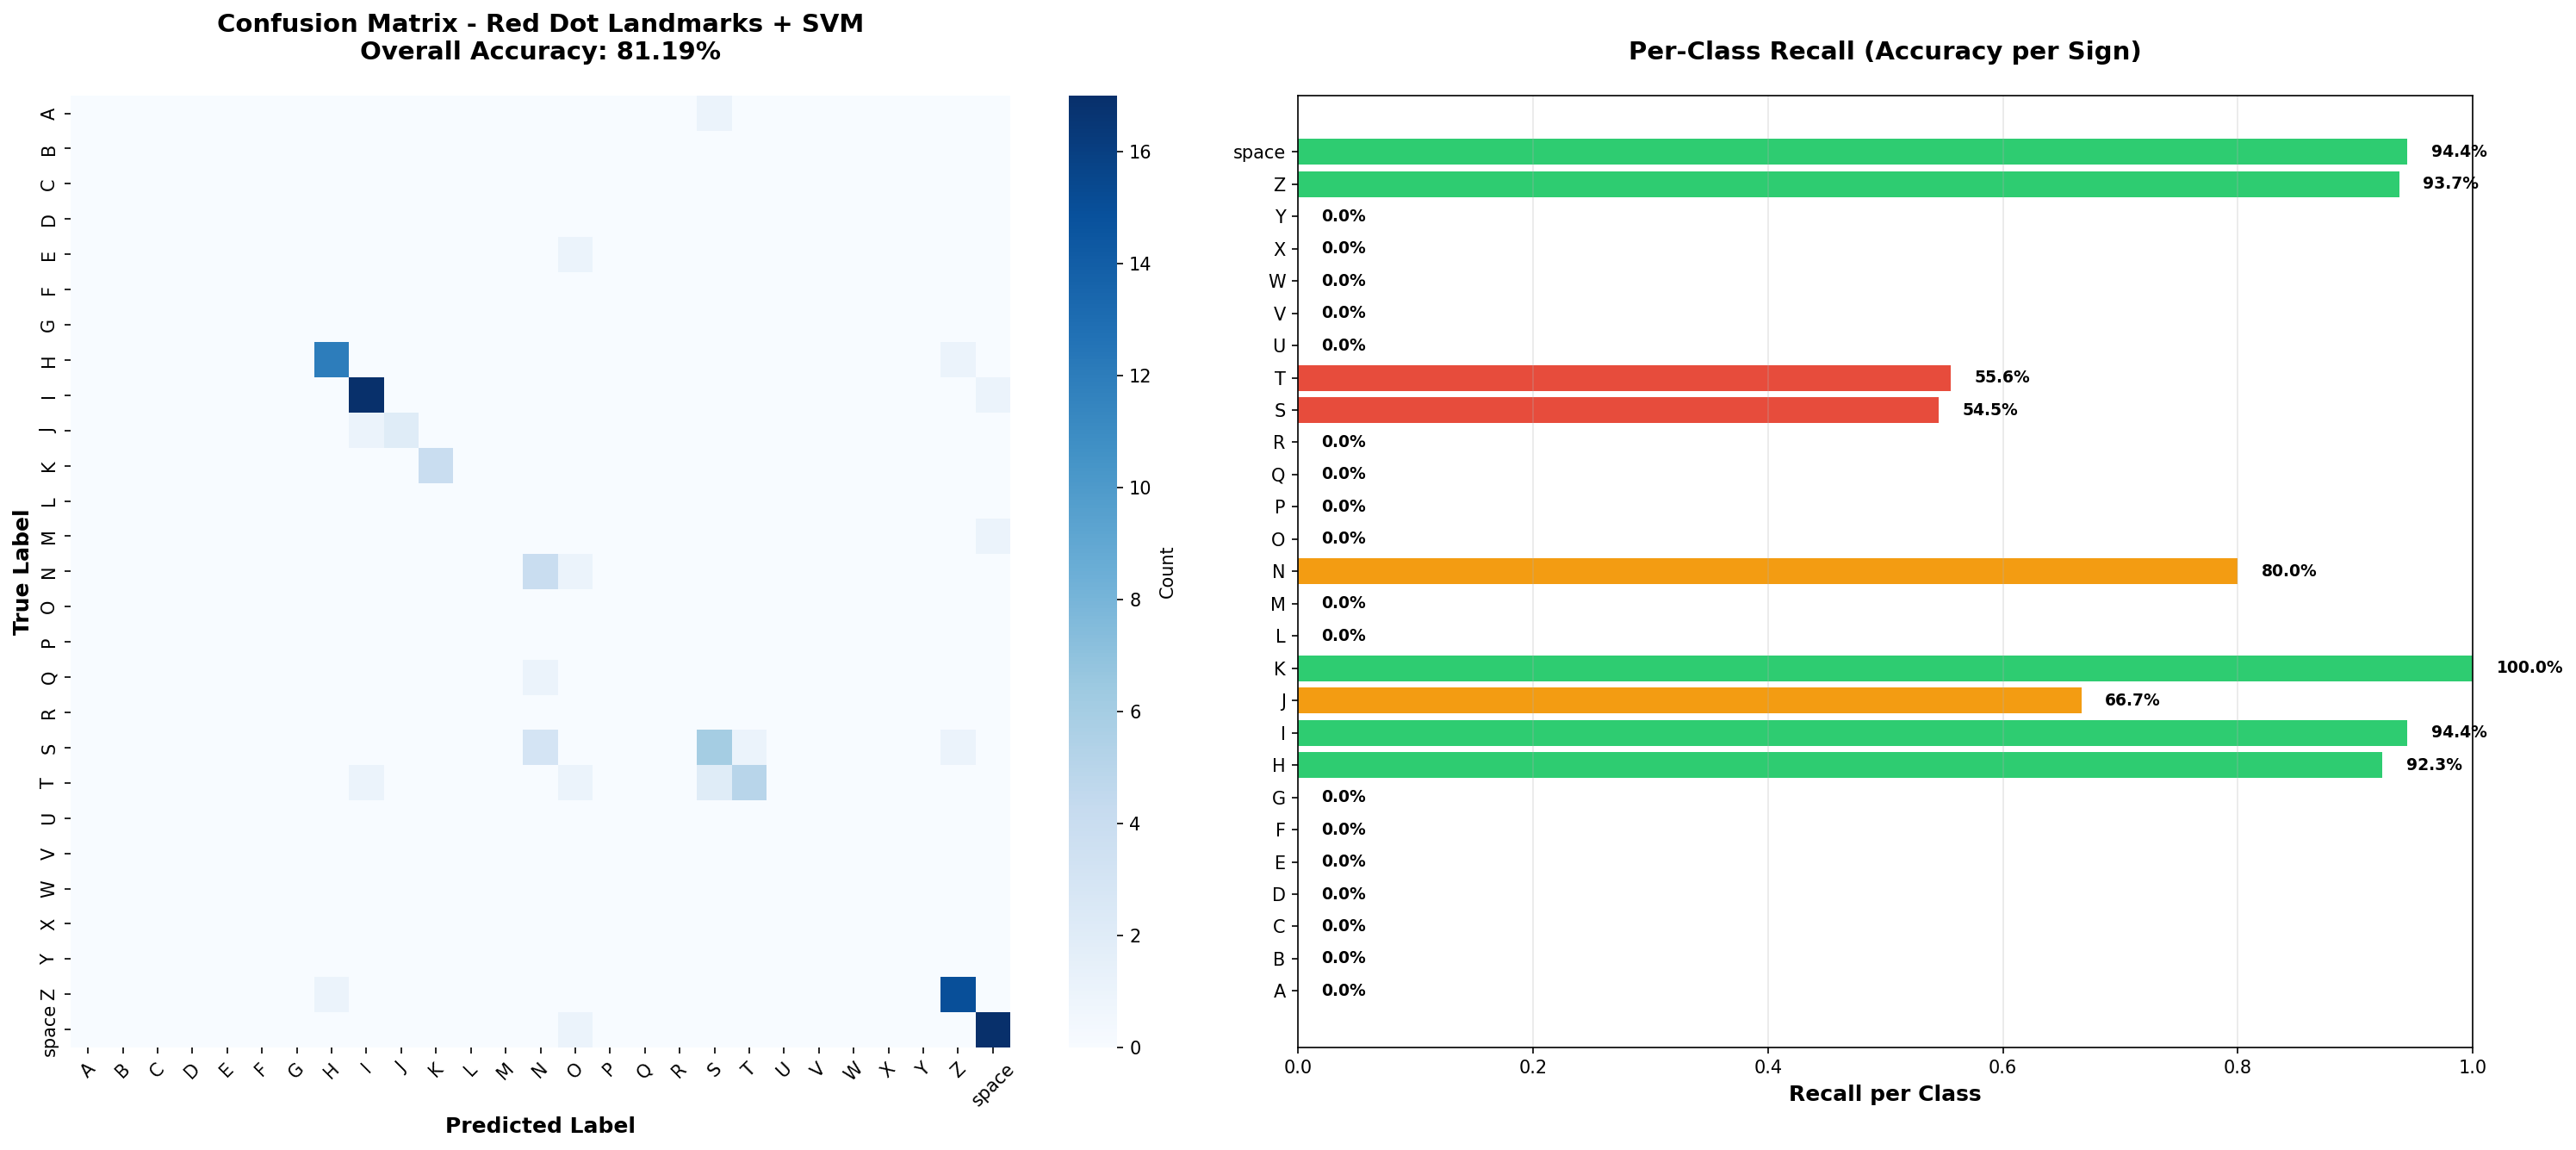

Saved: confusion_matrix_red_dots_svm.png
Saved: red_dots_svm_metrics.csv
Saved model: asl_red_dot_svm.joblib
Classes missing from usable TEST samples: ['B', 'C', 'D', 'F', 'G', 'L', 'O', 'P', 'R', 'U', 'V', 'W', 'X', 'Y']


In [3]:

# ============================================================
# 5) RED DOT LANDMARK EXTRACTION (Option B)
# ============================================================

def extract_red_dot_landmarks(
    image_bgr: np.ndarray,
    expected_points: int = 21,
    min_area: int = 4,     # lower -> fewer failures
    debug: bool = False
):
    """
    Detects the 21 red landmark dots already drawn on the dataset images.

    Steps:
      - HSV threshold for red (two hue ranges because red wraps)
      - Morphology to clean noise
      - Connected components to find blob centroids
      - Take largest 21 blobs
      - Normalize (center + scale)
      - Sort (by y then x) to get consistent ordering
      - Return 63-dim feature: (x,y,0) repeated

    Returns:
      (63,) float32 or None if not enough dots found.
    """
    if image_bgr is None:
        return None

    hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

    # More forgiving thresholds (helps your failure rate)
    lower1 = np.array([0, 50, 50], dtype=np.uint8)
    upper1 = np.array([10, 255, 255], dtype=np.uint8)
    lower2 = np.array([170, 50, 50], dtype=np.uint8)
    upper2 = np.array([180, 255, 255], dtype=np.uint8)

    mask1 = cv2.inRange(hsv, lower1, upper1)
    mask2 = cv2.inRange(hsv, lower2, upper2)
    mask = cv2.bitwise_or(mask1, mask2)

    # Clean noise
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel, iterations=1)

    # Find connected components (blobs)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

    blobs = []
    for i in range(1, num_labels):
        area = int(stats[i, cv2.CC_STAT_AREA])
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]

        if area < min_area:
            continue

        # circularity filter
        aspect_ratio = w / (h + 1e-6)
        if aspect_ratio < 0.5 or aspect_ratio > 2.0:
            continue

        cx, cy = centroids[i]
        blobs.append((area, float(cx), float(cy)))

    if len(blobs) < expected_points:
        return None

    # Take largest 21
    blobs.sort(reverse=True, key=lambda x: x[0])
    blobs = blobs[:expected_points]

    pts = np.array([[b[1], b[2]] for b in blobs], dtype=np.float32)  # (21,2)

    # Normalize: translation + scale
    center = pts.mean(axis=0)
    pts = pts - center
    scale = np.mean(np.linalg.norm(pts, axis=1)) + 1e-6
    pts = pts / scale

    # Sort for consistent feature order
    order = np.lexsort((pts[:, 0], pts[:, 1]))  # y then x
    pts = pts[order]

    # Build (21,3) with z=0
    feats = np.zeros((expected_points, 3), dtype=np.float32)
    feats[:, 0:2] = pts

    if debug:
        dbg = image_bgr.copy()
        for _, cx, cy in blobs:
            cv2.circle(dbg, (int(cx), int(cy)), 6, (0, 255, 0), 2)
        plt.figure(figsize=(5,5))
        plt.title("Detected red dots (green circles)")
        plt.imshow(cv2.cvtColor(dbg, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

    return feats.flatten()


def load_landmark_features(root_dir: Path, debug_one: bool = False):
    X, y = [], []
    failed = 0
    total = 0
    did_debug = False

    for cls in class_names:
        folder = root_dir / cls
        for p in folder.glob("*"):
            if not is_image_file(p):
                continue
            total += 1
            img = cv2.imread(str(p))
            feats = extract_red_dot_landmarks(img, debug=False)

            if feats is None:
                failed += 1
                continue

            X.append(feats)
            y.append(class_to_idx[cls])

            if debug_one and not did_debug:
                print("Debug example:", p)
                extract_red_dot_landmarks(img, debug=True)
                did_debug = True

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int64), failed, total


print("\nExtracting red-dot landmarks for TRAIN...")
X_train, y_train, failed_train, total_train = load_landmark_features(TRAIN_DIR, debug_one=True)

print("Extracting red-dot landmarks for TEST...")
X_test, y_test, failed_test, total_test = load_landmark_features(TEST_DIR, debug_one=False)

print("\n--- EXTRACTION SUMMARY ---")
print(f"Train total: {total_train}, usable: {len(X_train)}, failed: {failed_train}")
print(f"Test  total: {total_test}, usable: {len(X_test)},  failed: {failed_test}")
print("Feature dim:", X_train.shape[1] if len(X_train) else None)

if len(X_train) == 0 or len(X_test) == 0:
    raise RuntimeError("No usable samples extracted. Tune HSV thresholds or min_area.")

# Save arrays (optional)
np.save("asl_red_dots_X_train.npy", X_train)
np.save("asl_red_dots_y_train.npy", y_train)
np.save("asl_red_dots_X_test.npy",  X_test)
np.save("asl_red_dots_y_test.npy",  y_test)
np.save("asl_red_dot_labels.npy",   np.array(class_names, dtype=object))
print("Saved: asl_red_dots_* arrays + labels")

# ============================================================
# 6) TRAIN SVM
# ============================================================
svm = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", C=10, gamma="scale", class_weight="balanced")
)

print("\nTraining SVM...")
svm.fit(X_train, y_train)

pred = svm.predict(X_test)
acc = accuracy_score(y_test, pred)

print("\nSVM Accuracy:", acc)

# IMPORTANT FIX: force report to include all 27 classes even if some are missing
labels_all = np.arange(num_classes)

print("\nClassification Report:\n")
print(classification_report(
    y_test, pred,
    labels=labels_all,
    target_names=class_names,
    digits=4,
    zero_division=0
))

# ============================================================
# 7) CONFUSION MATRIX + PER CLASS RECALL (like Project 1)
# ============================================================
cm = confusion_matrix(y_test, pred, labels=labels_all)
per_class_recall = np.diag(cm) / (cm.sum(axis=1) + 1e-9)

fig, axes = plt.subplots(1, 2, figsize=(20, 9), dpi=150)

# Confusion Matrix Heatmap
ax1 = axes[0]
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={"label": "Count"}, ax=ax1)
ax1.set_xlabel("Predicted Label", fontsize=12, fontweight="bold")
ax1.set_ylabel("True Label", fontsize=12, fontweight="bold")
ax1.set_title(f"Confusion Matrix - Red Dot Landmarks + SVM\nOverall Accuracy: {acc*100:.2f}%",
              fontsize=14, fontweight="bold", pad=20)
ax1.tick_params(axis="x", rotation=45)

# Per-class recall bar chart
ax2 = axes[1]
colors = ['#2ecc71' if x > 0.8 else '#f39c12' if x > 0.6 else '#e74c3c'
          for x in per_class_recall]
bars = ax2.barh(class_names, per_class_recall, color=colors)
ax2.set_xlabel("Recall per Class", fontsize=12, fontweight="bold")
ax2.set_title("Per-Class Recall (Accuracy per Sign)", fontsize=14, fontweight="bold", pad=20)
ax2.set_xlim(0, 1)
ax2.grid(axis="x", alpha=0.3)

for i, val in enumerate(per_class_recall):
    ax2.text(val + 0.02, i, f"{val*100:.1f}%", va="center",
             fontsize=9, fontweight="bold")

plt.tight_layout()
plt.savefig("confusion_matrix_red_dots_svm.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: confusion_matrix_red_dots_svm.png")

# ============================================================
# 8) SAVE METRICS CSV (like Project 1)
# ============================================================
metrics_df = pd.DataFrame({
    "Class": class_names,
    "Recall": per_class_recall,
    "Total_Samples": cm.sum(axis=1),
    "Correct_Predictions": np.diag(cm)
})
metrics_df["Recall_Percent"] = metrics_df["Recall"] * 100

overall = pd.DataFrame([{
    "Class": "OVERALL",
    "Recall": acc,
    "Total_Samples": int(cm.sum()),
    "Correct_Predictions": int(np.diag(cm).sum()),
    "Recall_Percent": acc * 100
}])

metrics_df = pd.concat([metrics_df, overall], ignore_index=True)
metrics_df.to_csv("red_dots_svm_metrics.csv", index=False)
print("Saved: red_dots_svm_metrics.csv")

# ============================================================
# 9) SAVE MODEL
# ============================================================
joblib.dump(svm, "asl_red_dot_svm.joblib")
print("Saved model: asl_red_dot_svm.joblib")

# ============================================================
# 10) OPTIONAL: check which classes were missing from usable test samples
# ============================================================
present = np.unique(y_test)
missing = [class_names[i] for i in range(num_classes) if i not in present]
print("Classes missing from usable TEST samples:", missing)

# ============================================================
# 11) OPTIONAL: predict a single image
# ============================================================
def predict_letter(image_path: Path, model, class_names):
    img = cv2.imread(str(image_path))
    feats = extract_red_dot_landmarks(img)
    if feats is None:
        return None
    idx = model.predict(feats.reshape(1, -1))[0]
    return class_names[int(idx)]

# Example:
# example_img = next((TEST_DIR / class_names[0]).glob("*.jpg"))
# print("Example prediction:", predict_letter(example_img, svm, class_names))
